# REMEMBER to start the spark cluster with the little star icon before executing the notebook


In [1]:
#!pip install pandas
#!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

## Read in local csv files

In [3]:
inputFile = 'Higgs100k.csv'

#into panda DF
%time dataset = pd.read_csv(inputFile)

CPU times: user 1.33 s, sys: 186 ms, total: 1.51 s
Wall time: 1.52 s


In [4]:
#then into spark dataframe...remember to start spark with the little icon

%time df = spark.createDataFrame(dataset)

CPU times: user 27.7 s, sys: 225 ms, total: 27.9 s
Wall time: 32 s


In [5]:
%time total_events = df.count()

print('There are '+str(total_events)+' events')

CPU times: user 12 ms, sys: 11.7 ms, total: 23.7 ms
Wall time: 7.01 s
There are 99999 events


## Now, try to read in from Minio


In [3]:
#!pip install liboidcagent requests xmltodict pandas boto3

In [6]:
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]
    
import requests
import xmltodict
r = requests.post("https://minio.cloud.infn.it",
                  data={
                      'Action':
                      "AssumeRoleWithWebIdentity",
                      'Version': "2011-06-15",
                      'WebIdentityToken': token,
                      'DurationSeconds': 9000
                  },
                  verify=True)

tree = xmltodict.parse(r.content)

credentials = dict(tree['AssumeRoleWithWebIdentityResponse']
                    ['AssumeRoleWithWebIdentityResult']['Credentials'])    

In [7]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

conf = (SparkConf()
         .setMaster("k8s://https://kubernetes:443")
         .setAppName("MyApp")
         .set("spark.executor.memory", "1g")
         .set("spark.executor.instances", "2")
         .set("spark.kubernetes.container.image", "dodasts/spark:v3.0.1")
# configure S3 access  
         .set("spark.hadoop.fs.s3a.endpoint", "https://minio.cloud.infn.it")
         .set("spark.hadoop.fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider")
         .set("spark.hadoop.fs.s3a.access.key", credentials["AccessKeyId"])
         .set("spark.hadoop.fs.s3a.secret.key", credentials["SecretAccessKey"]) 
         .set("spark.hadoop.fs.s3a.session.token", credentials["SessionToken"])
         .set("spark.hadoop.fs.s3a.path.style.access","true")
         .set("spark.hadoop.fs.s3a.fast.upload", "true")
         .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
         .set("spark.hadoop.fs.s3a.committer.name", "directory")
       )

#first stop spark context
SparkContext.stop(sc)

#Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()
#spark = SparkSession(sc) # this would also work
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

In [11]:
# read the CSV with some options         
df = spark.read.options(header='True',inferSchema='True').csv("s3a://legger/MLCourseInput/Higgs1M.csv")

In [12]:
#In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(df.rdd.getNumPartitions()))
print("Partitioner: {}".format(df.rdd.partitioner))

Number of partitions: 4
Partitioner: None


# Now let's have a look at the input data

In [13]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: 

# Exercise 3

- Create a function that makes a plot of any of the above variable for signal versus background (using the label variable to discriminate)
  - see an example of the plot in the hands-on [slides](https://github.com/leggerf/MLCourse-1920/blob/master/Slides/Day1/ML-handson-day1.pdf)
  - the function should take as input the dataframe *df* and the variable name. For example `plotSignalvsBg(df, 'm_bb')`
  - to develop the code, use the 100k dataset, so that debugging goes quicker
- try to plot a few input variables and try to understand which ones are more promising to distinguish signal from background  

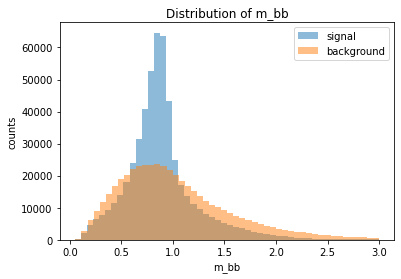

In [14]:
#plot invariant mass distribution 
plotSignalvsBg(df, 'm_bb')

# Exercise 4 - Bonus

#### Create the input feature vector

- Libraries for ML tipically take as inputs data in a very specific format. Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html
- Try to add to the dataframe df a new column, called 'features' which is a vector column with all the variables above except for 'label'
   - features = [lepton_pT, lepton_eta, lepton_phi, ...]
   - Hint: look at the VectorAssembler transformer

In [15]:
#create input vector for ML (features)
feature = df.columns
feature.remove('label')

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
df = assembler.transform(df)

#take a look at how there is now a features column
display(df)
df.select('features').take(1)

#note also that features are already standardised between -1 and 1, so rescaling won't be needed

DataFrame[_c0: int, label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

[Row(features=DenseVector([0.0, 0.8693, -0.6351, 0.2257, 0.3275, -0.69, 0.7542, -0.2486, -1.0921, 0.0, 1.375, -0.6537, 0.9303, 1.1074, 1.1389, -1.5782, -1.047, 0.0, 0.6579, -0.0105, -0.0458, 3.102, 1.3538, 0.9796, 0.9781, 0.92, 0.7217, 0.9888, 0.8767]))]

In [17]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()